# Exploration of Dimension Reduction
<span style="font-weight:bold; font-size:17pt; color:#666666;">XGBoost for feature selection</span>
<hr>

This notebook is for EDA, feature extraction, engineering and the subsequent evaluation of XGBoost as a dimension reduction technique.

It assumes the data (**features.h5**, the full feature set) is in a sub-directory of the **/data** folder. I've already added entries to the _.gitignore_ file so that they won't be committed to the repository. Note that this file should be updated for new versions of the data.

See the [data readme in the Gitbug repository](https://github.com/BrianDavisMath/FDA-COVID19/tree/master/data) for more details.

<hr>

In [1]:
%pylab inline
%autosave 25

import h5py
import random
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Data location

Change this when you get a new data set.

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

## Load the data from features.h5
<hr>

In [3]:
store = pd.HDFStore(data_loc + 'features.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 184,063, columns: 17,076


## Experiment 1

XGBoost for features extraction.

* in cid-pid space, for each active cid set:
    1. retain the closest point to the centroid (the mean of the pid vectors for a given cid)
    1. retain the furthest point from the centroid
* in cid-pid space, for each inactive cid set:
    1. retain the closest point to the centroid
    1. retain the furthest point from the centroid
* balance the set according to number of active and inactive transitions by add/removing samples
* determine number of epochs for training XGBoost
* grid/random search parameter space to finie tune parameters
* return the top 1,000 features, according to gain, as a candidate set

## Group

#### Group by cid and activity so we can find the centroid and furthest from the centroid in each group

In [5]:
df_grouped = df_features.groupby(['cid', 'activity'])

In [6]:
# Look at the group ("vertical") for cid 204 with active interactions.
df_grouped.get_group((204, 1))

,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
41,204,CAA96025,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
43,204,XP_717710,1,2.749244,-1.000000,-1.0,-1.0,2.904278,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
44,204,O86157,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
52,204,AAC57158,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
54,204,YP_001331689,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
58,204,Q99VQ4,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
60,204,P57771,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
62,204,P01584,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
64,204,ABY84639,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
72,204,O95372,1,0.249478,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


## Get the representative CIDs

In [24]:
def get_representative_cid_indices(df_group):
    # remove cid, pid and activity
    df_group.drop(['cid', 'pid', 'activity'],axis=1,inplace=True)
    
    centroid = df_group.mean().values
    distances = np.sqrt((np.square(df_group.values[:,np.newaxis]-centroid).sum(axis=2)))

    idx = df_group.index
    closest_idx_to_centroid = idx[distances.argmin()]
    furthest_idx_to_centroid = idx[distances.argmax()]
    
    return [closest_idx_to_centroid, furthest_idx_to_centroid]

In [25]:
from IPython.display import display, clear_output

num_groups = len(df_grouped.groups)
print('num groups: {:,}.'.format(num_groups))

indices = []
i = 1
for (cid, activity), group in df_grouped:
    indices.append(get_representative_cid_indices(group))
    clear_output(wait=True)
    display('processed cid group {:,} of {:,}'.format(i, num_groups))
    i = i + 1

indices = np.unique(np.array(indices).flatten())

len(indices)

'processed cid group 89,757 of 89,757'

104063

### Save indices to file

In [27]:
indices = np.array(indices)
h5f = h5py.File(data_loc+'indices.h5', 'w')
h5f.create_dataset('dataset_1', data=indices)
h5f.close()

# test reload from file
h5f = h5py.File(data_loc+'indices.h5','r')
b = h5f['dataset_1'][:]
h5f.close()

assert(np.allclose(indices, b)) # check our retrieved indices are the same

### Load indices from file

In [4]:
h5f = h5py.File(data_loc+'indices.h5','r')
indices = h5f['dataset_1'][:]
h5f.close()

print(len(indices))

104063


### Check balance of active vs inactive

In [5]:
cids = df_features[df_features.index.isin(indices)]

In [6]:
grouped = cids.groupby('cid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)

z = df_grouped_stacked[df_grouped_stacked[1] == 0]
nz = df_grouped_stacked[df_grouped_stacked[1] > 0]
print('there are {:,} drugs with zero activation'.format(len(z)))
print('there are {:,} drugs with an activation'.format(len(nz)))

there are 78,707 drugs with zero activation
there are 8,609 drugs with an activation


### Remove indices with no active label

In [7]:
rows_to_remove = df_grouped_stacked[df_grouped_stacked[1] == 0]['cid'].values.tolist()
del df_features
df_features = cids[~cids['cid'].isin(rows_to_remove)]
print(len(df_features))
df_features.head()

14984


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
58,204,Q99VQ4,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
97,204,EDT84149,0,3.936758,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
98,204,AAX80043,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
126,204,P0C6X7,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
136,8549,P08659,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


### Balance

In [8]:
# Add some of the inactive rows back in to balance the classes.

num_to_add = len(df_features) - len(nz)
print('adding {:,} inactive rows'.format(num_to_add))

rows_to_add = random.sample(rows_to_remove, num_to_add)
df_add = cids[cids['cid'].isin(rows_to_add)]

df_features = df_features.append(df_add)

print(len(df_features))
df_features.head()

adding 6,375 inactive rows
22230


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
58,204,Q99VQ4,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
97,204,EDT84149,0,3.936758,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
98,204,AAX80043,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
126,204,P0C6X7,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
136,8549,P08659,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
grouped = df_features.groupby('cid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)

In [10]:
df_grouped_stacked.head()

,cid,0,1
0,6,1.0,2.0
1,11,0.0,1.0
2,13,0.0,2.0
3,19,0.0,2.0
4,40,0.0,2.0


### Distribution of sampled CIDs

total number of cid-pid rows: 22,230
number of features: 17,076

there are 6,375 drugs with zero activation
there are 8,609 drugs with an activation
there are 6,168 drugs with only an activation



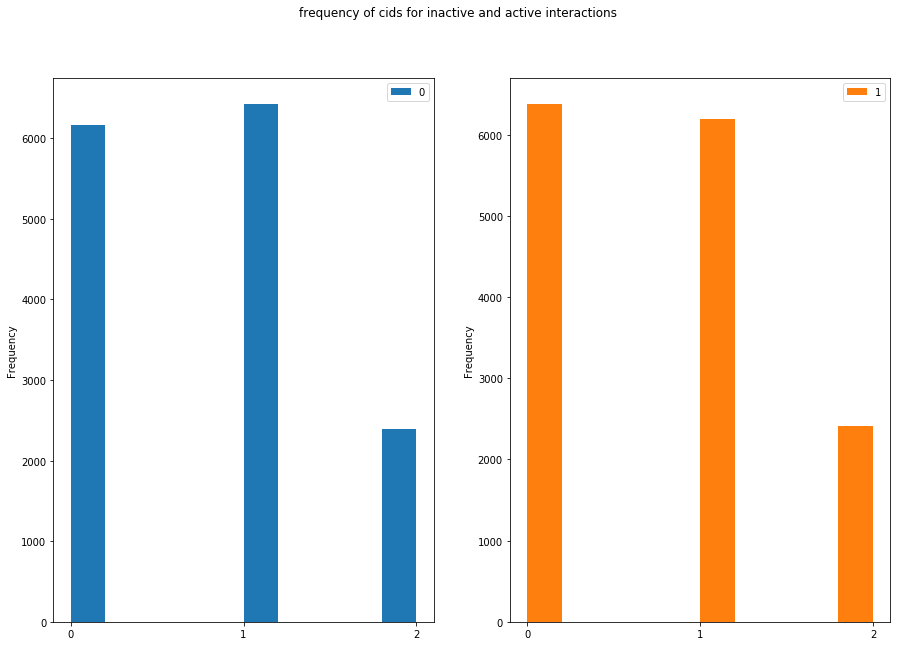

In [11]:
axes = df_grouped_stacked[[0, 1]].plot(kind = 'hist', subplots=True, layout = (1, 2), 
  title="frequency of cids for inactive and active interactions",
  figsize=(15, 10), xticks=[0, 1, 2], )

print('total number of cid-pid rows: {:,}'.format(len(df_features)))
print('number of features: {:,}\n'.format(len(df_features.columns)))

z = df_grouped_stacked[df_grouped_stacked[1] == 0]
nz = df_grouped_stacked[df_grouped_stacked[1] > 0]
onz = df_grouped_stacked[(df_grouped_stacked[1] > 0) & (df_grouped_stacked[0] == 0)]
print('there are {:,} drugs with zero activation'.format(len(z)))
print('there are {:,} drugs with an activation'.format(len(nz)))
print('there are {:,} drugs with only an activation\n'.format(len(onz)))

### Distribution of PIDs within sample

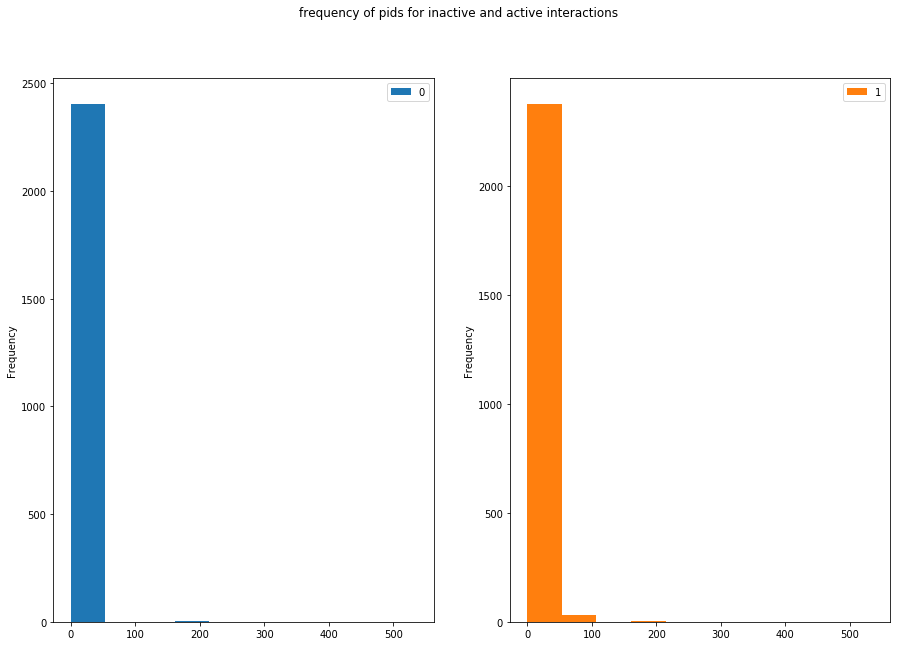

In [12]:
del df_grouped_stacked
grouped = df_features.groupby('pid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)

axes = df_grouped_stacked[[0, 1]].plot(kind = 'hist', subplots=True, layout = (1, 2), 
  title="frequency of pids for inactive and active interactions",
  figsize=(15, 10))

# XGBoost

reference material:

* [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
* [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
*[Python's Xgoost: ValueError('feature_names may not contain \[, \] or <')](https://stackoverflow.com/questions/48645846/pythons-xgoost-valueerrorfeature-names-may-not-contain-or/50633571)

In [13]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

### Fix column names

#### XGBoost does not like <>, [] and , in column names

In [14]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_features.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_features.columns.values]

In [15]:
Y = df_features['activity'].values
X = df_features.drop(['activity', 'cid', 'pid'], axis=1)

## XGBoost parameter tuning

Play around with fitting a model and see if we can narrow down the parameter search space for subsequent fine tuning.

reference material:

* [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
* [A Gentle Introduction to Early Stopping to Avoid Overtraining Neural Networks](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/)

### First evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

xgb.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=50)

# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### Grid search to find number of epochs (n_estimators)

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', silent=True, nthread=1)

n_estimators = range(100, 1000, 200) # try 5 different numbers of epochs

print('set of n_estimators to test: {}'.format([x for x in n_estimators]))

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, label_encoded_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

### Early stopping to refine number of epochs

It is suggested that a sensible early stoppinig parameter is 10% of _n_estimators_.

## Randomized parameter space search

Now we have an idea about the number of epochs to use lets carry out a parameter search to refine the other parameters.

reference material:

* [Kaggle: Hyperparameter Grid Search with XGBoost](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)

### Define a timer

In [21]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


### Set up the parameter space

In [22]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

fit_params = {
    'early_stopping_rounds': 30,
    'eval_metric': 'mae'
}

### run XGBoost

In [23]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(X,Y), 
    verbose=3, 
    random_state=1001)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

### Feature importance

reference material:

* [The Multiple faces of ‘Feature importance’ in XGBoost](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)